## environment setup and data preparation

In [ ]:
# 1. Environment Setup (Added pyarrow for parquet support)
!pip install econml xgboost lightgbm pyarrow -q

import pandas as pd
import numpy as np
import sklearn
import econml
import xgboost
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Reproducibility: print key versions
print(f"EconML Version: {econml.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"XGBoost Version: {xgboost.__version__}")
print(f"LightGBM Version: {lgb.__version__}")

# 2. Data Loading (Parquet preferred to preserve dtypes)
df = pd.read_parquet("final_bogo_dataset_sampleA.parquet", engine="pyarrow")
print(f"Loaded dataset shape: {df.shape}")

# 3. Variable Definitions & Guardrail List
Y_COL = "total_spend_in_window"   # Outcome (continuous)
T_COL = "treatment"               # Treatment (viewed=1, not viewed=0)

# Columns that should NEVER be used as model features (guardrail list)
DROP_COLS = ["customer_id", "became_member_on", "t_view", "received_offer", "t0"]

# 4. Feature Engineering: Tenure (Corrected t0 logic, Integrated with Clip Fix)
df["became_member_on"] = pd.to_datetime(df["became_member_on"], errors="coerce")

# Using the dummy anchor for experiment start
EXP_START = pd.Timestamp("2018-01-01")
offer_received_dt = EXP_START + pd.to_timedelta(df["t0"], unit="h")

# Calculate raw tenure days
df["user_tenure_days"] = (offer_received_dt - df["became_member_on"]).dt.days
# Fill missing values with median before clipping
df["user_tenure_days"] = df["user_tenure_days"].fillna(df["user_tenure_days"].median())

# --- Add Logic: Clip negatives to 0 ---
neg_before = float((df["user_tenure_days"] < 0).mean())
df["user_tenure_days"] = df["user_tenure_days"].clip(lower=0)
neg_after = float((df["user_tenure_days"] < 0).mean())

print(f"Tenure < 0 ratio (before clip): {neg_before:.2%}")
print(f"Tenure < 0 ratio (after clip):  {neg_after:.2%}")
print("Tenure (days) summary after clip:", df["user_tenure_days"].describe().to_dict())
# --------------------------------------------------

# 5. Define X columns (core demographics + pre-spend + engineered tenure + pragmatic controls)
X_COLS = [
    "age", "income", "gender",
    "pre_treatment_spend_30d",
    "user_tenure_days",
    "other_offers_received_events_in_window",
    "other_offers_viewed_events_in_window",
    "other_offers_received_unique_in_window",
    "other_offers_viewed_unique_in_window",
]

# Guardrail: ensure leakage columns are NOT in the feature list
leakage = set(DROP_COLS) & set(X_COLS)
assert not leakage, f"Leakage columns found in X_COLS: {leakage}"

# 6. Minimal Sanity Checks on T and Y
# Ensure treatment is binary int
df[T_COL] = df[T_COL].astype(int)
assert set(df[T_COL].unique()) <= {0, 1}, f"Unexpected treatment values: {df[T_COL].unique()}"

print("Treatment distribution:", df[T_COL].value_counts(normalize=True).to_dict())
print("Outcome summary:", df[Y_COL].describe()[["count", "mean", "std", "min", "max"]].to_dict())

# 7. Preprocessing (One-hot encode gender)
df_model = df[X_COLS + [Y_COL, T_COL]].copy()
df_processed = pd.get_dummies(df_model, columns=["gender"], drop_first=True)

# Final feature list after dummy expansion
X_FEATURES = [c for c in df_processed.columns if c not in [Y_COL, T_COL]]
print(f"Final X feature count: {len(X_FEATURES)}")
print(f"Final X features: {X_FEATURES}")

# 8. Train/Test Split (Stratified by treatment)
df_train, df_test = train_test_split(
    df_processed,
    test_size=0.3,
    random_state=42,
    stratify=df_processed[T_COL]
)

# Organize arrays for modeling
X_train = df_train[X_FEATURES]
T_train = df_train[T_COL]
Y_train = df_train[Y_COL]

X_test = df_test[X_FEATURES]
T_test = df_test[T_COL]
Y_test = df_test[Y_COL]

print("Setup Complete.")
print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Treatment Ratio (Train): {T_train.mean():.2%} | Treatment Ratio (Test): {T_test.mean():.2%}")

EconML Version: 0.16.0
Scikit-Learn Version: 1.6.1
XGBoost Version: 3.2.0
LightGBM Version: 4.6.0
Loaded dataset shape: (5542, 15)
Tenure < 0 ratio (before clip): 22.50%
Tenure < 0 ratio (after clip):  0.00%
Tenure (days) summary after clip: {'count': 5542.0, 'mean': 351.9882713821725, 'std': 398.774011878479, 'min': 0.0, '25%': 15.25, '50%': 163.0, '75%': 610.0, 'max': 1637.0}
Treatment distribution: {1: 0.5268856008661134, 0: 0.4731143991338867}
Outcome summary: {'count': 5542.0, 'mean': 28.316317214002165, 'std': 53.91530955314229, 'min': 0.0, 'max': 999.55}
Final X feature count: 10
Final X features: ['age', 'income', 'pre_treatment_spend_30d', 'user_tenure_days', 'other_offers_received_events_in_window', 'other_offers_viewed_events_in_window', 'other_offers_received_unique_in_window', 'other_offers_viewed_unique_in_window', 'gender_M', 'gender_O']
Setup Complete.
Training samples: 3879 | Test samples: 1663
Treatment Ratio (Train): 52.69% | Treatment Ratio (Test): 52.68%


In [ ]:
neg = df["user_tenure_days"][df["user_tenure_days"] < 0]
print("Negative tenure count:", len(neg))
print(neg.describe())

# check negative values within bins
bins = [-10**9, -365, -180, -90, -30, -7, -1, 0]
labels = ["<=-365","-365~-180","-180~-90","-90~-30","-30~-7","-7~-1","-1~0"]
print(pd.cut(neg, bins=bins, labels=labels).value_counts().sort_index())


Negative tenure count: 0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: user_tenure_days, dtype: float64
user_tenure_days
<=-365       0
-365~-180    0
-180~-90     0
-90~-30      0
-30~-7       0
-7~-1        0
-1~0         0
Name: count, dtype: int64


In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names.*LGBM.*"
)

## Uplift models(T-learner and Casual Engine)

In [ ]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# 1. Initialize learners (with current best-practice params)
xgb_params = dict(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    n_jobs=-1
)

model_t1 = XGBRegressor(**xgb_params)
model_t0 = XGBRegressor(**xgb_params)

# Column order guardrail
assert list(X_train.columns) == list(X_test.columns), "Feature order mismatch!"

# 2. Prepare masks and Print Sample Sizes
mask_t1 = (T_train == 1)
mask_t0 = (T_train == 0)

# Transparency on group sizes
print(f"Training Group Sizes -> Treated (T=1): {mask_t1.sum()} | Control (T=0): {mask_t0.sum()}")

# 3. Fit Models
model_t1.fit(X_train[mask_t1], Y_train[mask_t1])
model_t0.fit(X_train[mask_t0], Y_train[mask_t0])

# 4. Predict Uplift(Predict counterfactuals on the test set)
# Uplift = Potential Outcome if treated - Potential Outcome if control
pred_y1 = model_t1.predict(X_test)
pred_y0 = model_t0.predict(X_test)
uplift_tlearner = pred_y1 - pred_y0

# 5. Results DataFrame(Consolidate results using numpy to avoid index alignment issues)
df_results = pd.DataFrame({
    "y_true": Y_test.to_numpy(),
    "w_true": T_test.to_numpy(),
    "uplift_tlearner": uplift_tlearner
})

# Descriptive Stats (using percentiles to see the long tail)
print("\nT-Learner Uplift Distribution (Percentiles):")
print(np.percentile(uplift_tlearner, [1, 25, 50, 75, 99]))

# Sanity Check: ATE Direction
ate_naive = df_results.loc[df_results.w_true == 1, "y_true"].mean() - \
            df_results.loc[df_results.w_true == 0, "y_true"].mean()
print(f"\nNaive Diff-in-Means: {ate_naive:.4f}")
print(f"Mean Predicted Uplift: {df_results['uplift_tlearner'].mean():.4f}")

Training Group Sizes -> Treated (T=1): 2044 | Control (T=0): 1835

T-Learner Uplift Distribution (Percentiles):
[-56.12647575   4.99237347  11.57853317  21.47982407 109.14956161]

Naive Diff-in-Means: 20.0478
Mean Predicted Uplift: 14.2205


In [ ]:
# Linear DML
from econml.dml import LinearDML
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import KFold

# Nuisance models (fast + strong on tabular)
model_y = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,verbose=-1
)

model_t = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,verbose=-1
)

# Cross-fitting folds
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Linear DML (CATE model is linear in X by default)
dml = LinearDML(
    model_y=model_y,
    model_t=model_t,
    cv=cv,
    discrete_treatment=True,
    random_state=42
)

Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()
Ytr = Y_train.to_numpy()
Ttr = T_train.to_numpy()

dml.fit(Ytr, Ttr, X=Xtr)
uplift_dml = dml.effect(Xte)
uplift_dml = np.asarray(uplift_dml, dtype=float).reshape(-1)  # ensure numeric 1D

# Add to df_results for apples-to-apples evaluation
df_results["uplift_dml"] = uplift_dml

print("DML complete.")
print(df_results["uplift_dml"].describe())
print("Mean uplift (DML):", df_results["uplift_dml"].mean())
print("dtype:", df_results["uplift_dml"].dtype)

DML complete.
count    1663.000000
mean       12.471820
std         8.112423
min       -17.042757
25%         7.369337
50%        12.584765
75%        17.798506
max        45.385684
Name: uplift_dml, dtype: float64
Mean uplift (DML): 12.47182042751282
dtype: float64


In [ ]:
# Casual Forest DML
import numpy as np
from econml.dml import CausalForestDML
from lightgbm import LGBMRegressor, LGBMClassifier

# --- Prepare numpy arrays (consistent dtypes/shapes) ---
Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()
Ytr = Y_train.to_numpy()
Ttr = T_train.to_numpy().astype(int)

# --- Nuisance models (moderate complexity, quiet logs) ---
model_y = LGBMRegressor(
    n_estimators=200, max_depth=3, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbose=-1
)

model_t = LGBMClassifier(
    n_estimators=200, max_depth=3, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbose=-1
)

# --- Causal Forest DML ---
cf_dml = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    n_estimators=300,        # smoke test; can increase to 500 after it works
    min_samples_leaf=20,
    max_depth=10,            # helps prevent overly complex trees
    discrete_treatment=True,
    cv=3,
    random_state=42
)

print("Training CausalForestDML...")
cf_dml.fit(Ytr, Ttr, X=Xtr)

uplift_cf = cf_dml.effect(Xte)
uplift_cf = np.asarray(uplift_cf, dtype=float).reshape(-1)
df_results["uplift_cf"] = uplift_cf

# Add to df_results for apples-to-apples evaluation
print("Casual DML complete.")
print(df_results["uplift_cf"].describe())
print("Mean uplift (DML):", df_results["uplift_cf"].mean())
print("dtype:", df_results["uplift_cf"].dtype)

Training CausalForestDML...
Casual DML complete.
count    1663.000000
mean       14.530794
std         6.547558
min         5.214410
25%        10.331004
50%        12.302144
75%        16.318710
max        42.451647
Name: uplift_cf, dtype: float64
Mean uplift (DML): 14.530793640748781
dtype: float64


## Evaluation Part A: Cumulative Top-K Uplift

In [ ]:
# -----------------------
# Part A: Cumulative Top-K Uplift (Recommended)
# -----------------------
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_uplift_by_topk(df, score_col, n_bins=10, title_prefix="Cumulative Top-K Uplift"):
    """
    score_col: 用来排序的列（建议直接传 *_rank）
              约定：score 越大 = 越应该优先投放（higher is better）
    """
    required = {"w_true", "y_true", score_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}. "
                         f"Did you run rank calibration to create {score_col}?")

    d = df[["w_true", "y_true", score_col]].copy()
    d = d.dropna(subset=[score_col])  # 防止 qcut 因 NaN 崩

    # Assign bins: 0=lowest, n_bins-1=highest
    d["bin"] = pd.qcut(d[score_col], n_bins, labels=False, duplicates="drop")
    max_bin = int(d["bin"].max()) # in case qcut drops bins

    rows = []
    # k=1 means Top 10%, k=2 means Top 20%...
    for k in range(1, max_bin + 2):
        cutoff = max_bin - (k - 1) # include bins >= cutoff_bin
        sub = d[d["bin"] >= cutoff]

        n1 = int((sub["w_true"] == 1).sum())
        n0 = int((sub["w_true"] == 0).sum())

        y1 = sub.loc[sub["w_true"] == 1, "y_true"].mean()
        y0 = sub.loc[sub["w_true"] == 0, "y_true"].mean()

        rows.append({
            "topk_pct": int(100 * k / (max_bin + 1)), # 10,20,... (if 10 bins)
            "n_treated": n1,
            "n_control": n0,
            "actual_uplift": float(y1 - y0) if (n1 > 0 and n0 > 0) else np.nan
        })

    res = pd.DataFrame(rows)

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(res)), res["actual_uplift"])
    plt.xticks(range(len(res)), [f"Top {p}%" for p in res["topk_pct"]])
    plt.xlabel("Targeting depth (Top-K by predicted uplift)")
    plt.ylabel("Actual lift (mean(Y|T=1) - mean(Y|T=0))")
    plt.title(f"{title_prefix}: {score_col}")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()

    display(res)
    return res

## Evaluation Part B: Qini curve / AUUC

### Evaluation Protocol (Uplift / CATE Ranking)

This notebook evaluates uplift models as **ranking models** (who to target first), not as perfectly calibrated causal effect estimators.

**Data split**
- One fixed train/test split (stratified by treatment) for reproducibility.

**Primary metrics**
1) **Cumulative Top-K Uplift**  
   - Sort users by a score (higher = higher priority).
   - For each K (Top 10%, 20%, …), compute:
     \[
     \Delta(K) = \mathbb{E}[Y \mid T=1, \text{Top-}K] - \mathbb{E}[Y \mid T=0, \text{Top-}K]
     \]
   - This answers: *“If we target the top K% recommended by the model, what lift do we actually observe?”*

2) **Qini curve & AUUC (Area Under the Uplift Curve)**  
   - Users are ordered by the model score.
   - Qini is computed as cumulative incremental outcome with control scaled to treated size.
   - AUUC is the area between the model Qini curve and a linear “random targeting” baseline.

**Rank calibration (sign / direction)**
Some causal estimators can produce effect values whose **sign is reversed for ranking** under a given implementation or evaluation convention.
To make evaluation robust, we automatically test:
- `score = uplift` (descending)
- `score = -uplift` (flipped)

We keep the direction that yields higher AUUC, and store it as `*_rank`.
> Convention used downstream: **higher `*_rank` means higher targeting priority**.


In [ ]:
import numpy as np

def get_qini_table(df, uplift_col):
    df = df.sort_values(uplift_col, ascending=False).reset_index(drop=True).copy()
    t = df["w_true"].to_numpy()
    y = df["y_true"].to_numpy()

    df["n_treated"] = np.cumsum(t)
    df["n_control"] = np.cumsum(1 - t)
    df["y_treated_cum"] = np.cumsum(y * t)
    df["y_control_cum"] = np.cumsum(y * (1 - t))

    eps = 1e-10
    df["qini"] = df["y_treated_cum"] - df["y_control_cum"] * (df["n_treated"] / (df["n_control"] + eps))
    total_qini = df["qini"].iloc[-1]
    df["random_qini"] = np.linspace(0, total_qini, len(df))
    return df

def get_auuc(df, uplift_col):
    q = get_qini_table(df, uplift_col)
    return np.trapezoid(q["qini"] - q["random_qini"]) / len(q)

def calibrate_rank_score(df, uplift_col, rank_col=None):
    if rank_col is None:
        rank_col = uplift_col + "_rank"

    # try desc
    auuc_desc = get_auuc(df, uplift_col)

    # try flipped
    tmp = df.copy()
    tmp[rank_col] = -tmp[uplift_col]
    auuc_flip = get_auuc(tmp, rank_col)

    if auuc_flip > auuc_desc:
        df[rank_col] = -df[uplift_col]
        best = "flip"
        best_auuc = auuc_flip
    else:
        df[rank_col] = df[uplift_col]
        best = "desc"
        best_auuc = auuc_desc

    meta = {
        "uplift_col": uplift_col,
        "rank_col": rank_col,
        "best_direction": best,
        "AUUC_best": best_auuc,
        "AUUC_desc": auuc_desc,
        "AUUC_flip": auuc_flip,
    }
    return df, meta

df_results, meta_dml = calibrate_rank_score(df_results, "uplift_dml", "uplift_dml_rank")
df_results, meta_cf  = calibrate_rank_score(df_results, "uplift_cf",  "uplift_cf_rank")
meta_dml, meta_cf


({'uplift_col': 'uplift_dml',
  'rank_col': 'uplift_dml_rank',
  'best_direction': 'flip',
  'AUUC_best': np.float64(1260.699225970955),
  'AUUC_desc': np.float64(-1275.9063802219046),
  'AUUC_flip': np.float64(1260.699225970955)},
 {'uplift_col': 'uplift_cf',
  'rank_col': 'uplift_cf_rank',
  'best_direction': 'desc',
  'AUUC_best': np.float64(1089.1972702681626),
  'AUUC_desc': np.float64(1089.1972702681626),
  'AUUC_flip': np.float64(-1361.9364926940093)})

## Evaluation Results


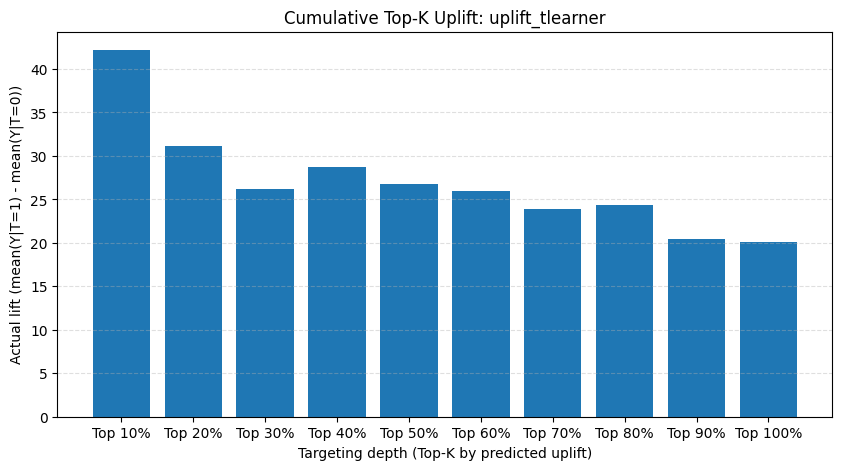

,topk_pct,n_treated,n_control,actual_uplift
0,10,85,82,42.180532
1,20,188,145,31.162774
2,30,282,217,26.179361
3,40,375,290,28.690471
4,50,452,379,26.737599
5,60,533,465,25.936738
6,70,609,555,23.913672
7,80,675,655,24.404002
8,90,771,725,20.426573
9,100,876,787,20.047764


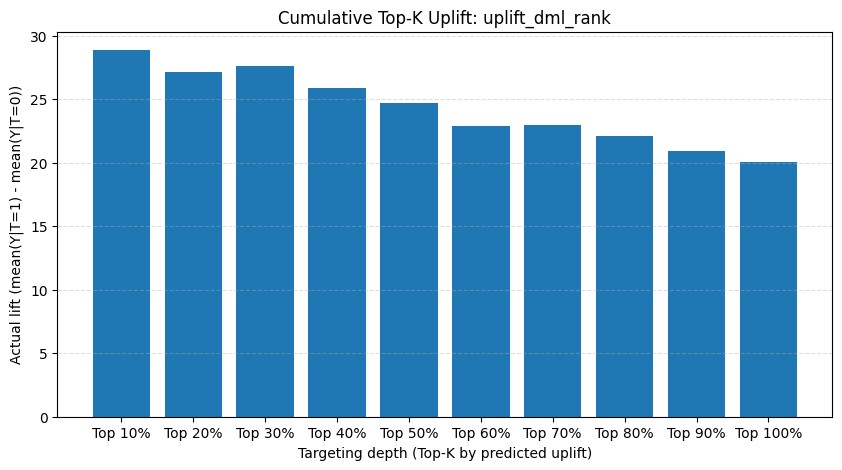

,topk_pct,n_treated,n_control,actual_uplift
0,10,79,88,28.861207
1,20,171,162,27.118944
2,30,260,239,27.633096
3,40,345,320,25.863424
4,50,428,403,24.693055
5,60,515,483,22.888409
6,70,601,563,22.946884
7,80,690,640,22.100580
8,90,798,698,20.882798
9,100,876,787,20.047764


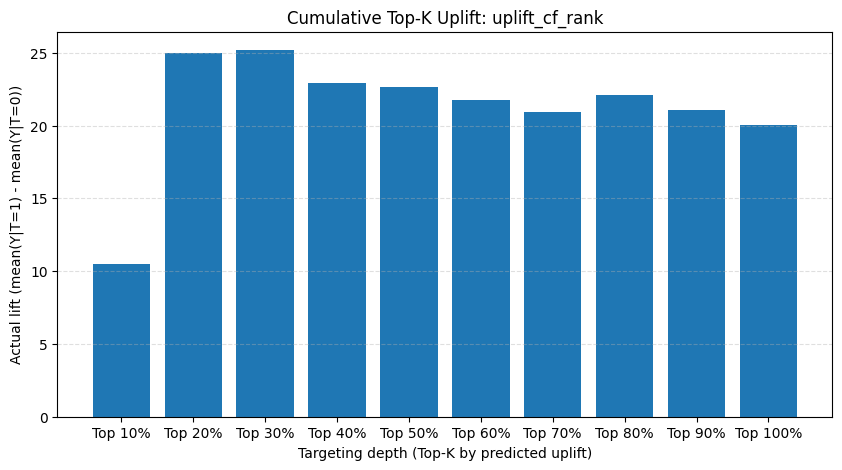

,topk_pct,n_treated,n_control,actual_uplift
0,10,85,82,10.466070
1,20,178,155,24.971441
2,30,273,226,25.183951
3,40,374,291,22.893008
4,50,467,364,22.662214
5,60,556,442,21.787168
6,70,645,519,20.947710
7,80,717,613,22.125671
8,90,793,703,21.073579
9,100,876,787,20.047764


,topk_pct,n_treated,n_control,actual_uplift
0,10,85,82,10.466070
1,20,178,155,24.971441
2,30,273,226,25.183951
3,40,374,291,22.893008
4,50,467,364,22.662214
5,60,556,442,21.787168
6,70,645,519,20.947710
7,80,717,613,22.125671
8,90,793,703,21.073579
9,100,876,787,20.047764


In [ ]:
plot_uplift_by_topk(df_results, "uplift_tlearner")
plot_uplift_by_topk(df_results, "uplift_dml_rank")
plot_uplift_by_topk(df_results, "uplift_cf_rank")


In [ ]:
df_results, meta_dml = calibrate_rank_score(df_results, "uplift_dml", rank_col="uplift_dml_rank")
df_results, meta_cf  = calibrate_rank_score(df_results, "uplift_cf",  rank_col="uplift_cf_rank")
print(meta_dml)
print(meta_cf)

{'uplift_col': 'uplift_dml', 'rank_col': 'uplift_dml_rank', 'best_direction': 'flip', 'AUUC_best': np.float64(1260.699225970955), 'AUUC_desc': np.float64(-1275.9063802219046), 'AUUC_flip': np.float64(1260.699225970955)}
{'uplift_col': 'uplift_cf', 'rank_col': 'uplift_cf_rank', 'best_direction': 'desc', 'AUUC_best': np.float64(1089.1972702681626), 'AUUC_desc': np.float64(1089.1972702681626), 'AUUC_flip': np.float64(-1361.9364926940093)}


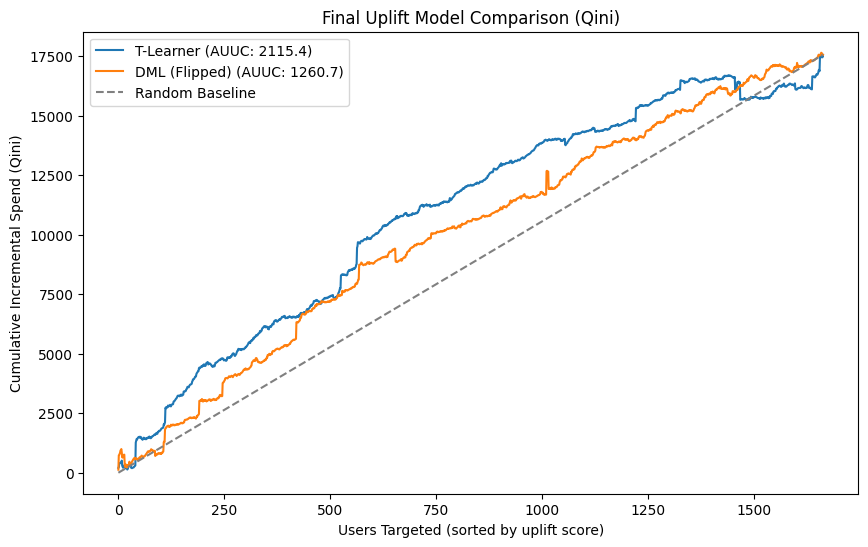

,Model,AUUC
0,T-Learner (XGB),2115.351695
1,LinearDML (Rank Flipped),1260.699226


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


# 2) Helper: AUUC from a Qini table (no recompute)
def auuc_from_qini(q_df):
    diff = (q_df["qini"] - q_df["random_qini"]).to_numpy()
    return np.trapezoid(diff) / len(q_df)

results_summary = []

# --- Compute Qini tables once ---
q_t = get_qini_table(df_results, "uplift_tlearner")
q_d = get_qini_table(df_results, "uplift_dml_rank")

auuc_t = auuc_from_qini(q_t)
auuc_d = auuc_from_qini(q_d)

results_summary.append({"Model": "T-Learner (XGB)", "AUUC": auuc_t})
results_summary.append({"Model": "LinearDML (Rank Flipped)", "AUUC": auuc_d})

# 3) Plot (use one fixed random baseline, e.g., from T-Learner)
plt.figure(figsize=(10, 6))
plt.plot(q_t["qini"], label=f"T-Learner (AUUC: {auuc_t:.1f})")
plt.plot(q_d["qini"], label=f"DML (Flipped) (AUUC: {auuc_d:.1f})")
plt.plot(q_t["random_qini"], label="Random Baseline", linestyle="--", color="gray")

plt.title("Final Uplift Model Comparison (Qini)")
plt.xlabel("Users Targeted (sorted by uplift score)")
plt.ylabel("Cumulative Incremental Spend (Qini)")
plt.legend()
plt.show()

display(pd.DataFrame(results_summary))


## Grid on Forest Casual DML

In [ ]:
import numpy as np
import pandas as pd
from econml.dml import CausalForestDML
from lightgbm import LGBMRegressor, LGBMClassifier

# ---------- Helper: AUUC (no trapz warning) ----------
def get_auuc(df, col):
    q_table = get_qini_table(df, col)
    diff = (q_table["qini"] - q_table["random_qini"]).to_numpy()
    return np.trapezoid(diff) / len(q_table)

# ---------- Prepare numpy arrays once ----------
Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()
Ytr = Y_train.to_numpy()
Ttr = T_train.to_numpy().astype(int)

# ---------- Nuisance models (fixed, quiet) ----------
def make_nuisance_models(seed=42):
    model_y = LGBMRegressor(
        n_estimators=200, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=seed, n_jobs=-1, verbose=-1
    )
    model_t = LGBMClassifier(
        n_estimators=200, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=seed, n_jobs=-1, verbose=-1
    )
    return model_y, model_t

# ---------- Small grid (6 runs) ----------
grid = [
    # (n_estimators, min_samples_leaf, max_depth)
    (300, 20, 10),
    (800, 20, 10),
    (300, 10, 10),
    (800, 10, 10),
    (300, 5,  10),
    (800, 5,  10),
]

rows = []

for n_estimators, min_leaf, max_depth in grid:
    model_y, model_t = make_nuisance_models(seed=42)

    cf = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        n_estimators=n_estimators,
        min_samples_leaf=min_leaf,
        max_depth=max_depth,
        discrete_treatment=True,
        cv=3,
        random_state=42
    )

    print(f"Running CF-DML: trees={n_estimators}, leaf={min_leaf}, depth={max_depth} ...")
    cf.fit(Ytr, Ttr, X=Xtr)

    uplift = cf.effect(Xte)
    uplift = np.asarray(uplift, dtype=float).reshape(-1)

    # Evaluate both directions (because direction can flip for ranking)
    tmp = df_results.copy()
    tmp["uplift_cf"] = uplift
    tmp["uplift_cf_rankflip"] = -uplift

    auuc_desc = get_auuc(tmp, "uplift_cf")
    auuc_flip = get_auuc(tmp, "uplift_cf_rankflip")

    best_auuc = max(auuc_desc, auuc_flip)
    best_dir = "desc" if auuc_desc >= auuc_flip else "flip"

    rows.append({
        "n_estimators": n_estimators,
        "min_samples_leaf": min_leaf,
        "max_depth": max_depth,
        "AUUC_desc": auuc_desc,
        "AUUC_flip": auuc_flip,
        "AUUC_best": best_auuc,
        "best_direction": best_dir
    })

results_cf = pd.DataFrame(rows).sort_values("AUUC_best", ascending=False).reset_index(drop=True)
display(results_cf)

best = results_cf.iloc[0].to_dict()
print("\nBEST CONFIG:", best)

# ---------- Fit best config once more and store final score into df_results ----------
best_n = int(best["n_estimators"])
best_leaf = int(best["min_samples_leaf"])
best_depth = int(best["max_depth"])
best_dir = best["best_direction"]

model_y, model_t = make_nuisance_models(seed=42)
cf_best = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    n_estimators=best_n,
    min_samples_leaf=best_leaf,
    max_depth=best_depth,
    discrete_treatment=True,
    cv=3,
    random_state=42
)

print(f"\nRefitting BEST CF-DML: trees={best_n}, leaf={best_leaf}, depth={best_depth} ...")
cf_best.fit(Ytr, Ttr, X=Xtr)
uplift_best = np.asarray(cf_best.effect(Xte), dtype=float).reshape(-1)

df_results["uplift_cf"] = uplift_best
df_results["uplift_cf_rank"] = (-uplift_best) if best_dir == "flip" else uplift_best

print(f"Stored df_results['uplift_cf_rank'] using direction = {best_dir}")
print("AUUC (best rank):", get_auuc(df_results, "uplift_cf_rank"))


Running CF-DML: trees=300, leaf=20, depth=10 ...
Running CF-DML: trees=800, leaf=20, depth=10 ...
Running CF-DML: trees=300, leaf=10, depth=10 ...
Running CF-DML: trees=800, leaf=10, depth=10 ...
Running CF-DML: trees=300, leaf=5, depth=10 ...
Running CF-DML: trees=800, leaf=5, depth=10 ...


,n_estimators,min_samples_leaf,max_depth,AUUC_desc,AUUC_flip,AUUC_best,best_direction
0,300,20,10,1089.197270,-1361.936493,1089.197270,desc
1,800,20,10,719.002196,-959.353659,719.002196,desc
2,300,10,10,199.785777,-467.348815,199.785777,desc
3,800,5,10,-245.118337,46.573984,46.573984,flip
4,800,10,10,-198.541353,-58.174374,-58.174374,flip
5,300,5,10,-92.730365,-114.168084,-92.730365,desc



BEST CONFIG: {'n_estimators': 300, 'min_samples_leaf': 20, 'max_depth': 10, 'AUUC_desc': 1089.1972702681626, 'AUUC_flip': -1361.9364926940093, 'AUUC_best': 1089.1972702681626, 'best_direction': 'desc'}

Refitting BEST CF-DML: trees=300, leaf=20, depth=10 ...
Stored df_results['uplift_cf_rank'] using direction = desc
AUUC (best rank): 1089.1972702681626


In [ ]:
# ==========================================
# FINAL: Save outputs for GitHub / reuse
# ==========================================
import os, json
import numpy as np
import pandas as pd

SAVE_DIR = "outputs_notebook02"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Core table: Combine X_test features with uplift scores
# Using reset_index(drop=True) ensures perfect alignment between features and scores
df_final_scored = pd.concat([
    X_test.reset_index(drop=True),
    df_results.reset_index(drop=True)
], axis=1)

# Save the combined dataset (This will be the main input for Notebook 03)
df_final_scored.to_parquet(f"{SAVE_DIR}/scored_sampleA.parquet", index=False)
df_final_scored.to_csv(f"{SAVE_DIR}/scored_sampleA.csv", index=False)

# 2) Rank calibration meta (convert np scalars to python scalars)
def _py(obj):
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    return obj

meta_bundle = {}
if "meta_dml" in globals():
    meta_bundle["meta_dml"] = {k: _py(v) for k, v in meta_dml.items()}
if "meta_cf" in globals():
    meta_bundle["meta_cf"] = {k: _py(v) for k, v in meta_cf.items()}

if meta_bundle:
    with open(f"{SAVE_DIR}/rank_calibration_meta.json", "w") as f:
        json.dump(meta_bundle, f, indent=2)

# 3) AUUC comparison table
if "results_summary" in globals():
    pd.DataFrame(results_summary).to_csv(f"{SAVE_DIR}/auuc_summary.csv", index=False)

# 4) Optional: save Qini tables
for var_name in ["qini_df", "q_t", "q_d", "q_cf"]:
    if var_name in globals() and isinstance(globals()[var_name], pd.DataFrame):
        globals()[var_name].to_parquet(f"{SAVE_DIR}/{var_name}.parquet", index=False)

print(f"Saved outputs to: {SAVE_DIR}")
print(f"Final scored dataset shape: {df_final_scored.shape}")
print("Files:", os.listdir(SAVE_DIR))

Saved outputs to: outputs_notebook02
Final scored dataset shape: (1663, 17)
Files: ['q_t.parquet', 'df_results.parquet', 'scored_sampleA.csv', 'scored_sampleA.parquet', 'df_results.csv', 'q_d.parquet', 'auuc_summary.csv', 'rank_calibration_meta.json']


In [ ]:
# 在 Notebook 02 的末尾运行此代码
# 保存带有模型分数的最终数据集，供 Notebook 03 使用
df_final_scored.to_parquet(f"{SAVE_DIR}/final_scored_dataset_sampleA.parquet", index=False)
print(f"Successfully saved: {SAVE_DIR}/final_scored_dataset_sampleA.parquet")

Successfully saved: outputs_notebook02/final_scored_dataset_sampleA.parquet


In [15]:
print(df_final_scored.shape)
print(df_final_scored.columns[:30])
print(df_final_scored.columns[-30:])

(1663, 17)
Index(['age', 'income', 'pre_treatment_spend_30d', 'user_tenure_days',
       'other_offers_received_events_in_window',
       'other_offers_viewed_events_in_window',
       'other_offers_received_unique_in_window',
       'other_offers_viewed_unique_in_window', 'gender_M', 'gender_O',
       'y_true', 'w_true', 'uplift_tlearner', 'uplift_dml', 'uplift_cf',
       'uplift_dml_rank', 'uplift_cf_rank'],
      dtype='object')
Index(['age', 'income', 'pre_treatment_spend_30d', 'user_tenure_days',
       'other_offers_received_events_in_window',
       'other_offers_viewed_events_in_window',
       'other_offers_received_unique_in_window',
       'other_offers_viewed_unique_in_window', 'gender_M', 'gender_O',
       'y_true', 'w_true', 'uplift_tlearner', 'uplift_dml', 'uplift_cf',
       'uplift_dml_rank', 'uplift_cf_rank'],
      dtype='object')
